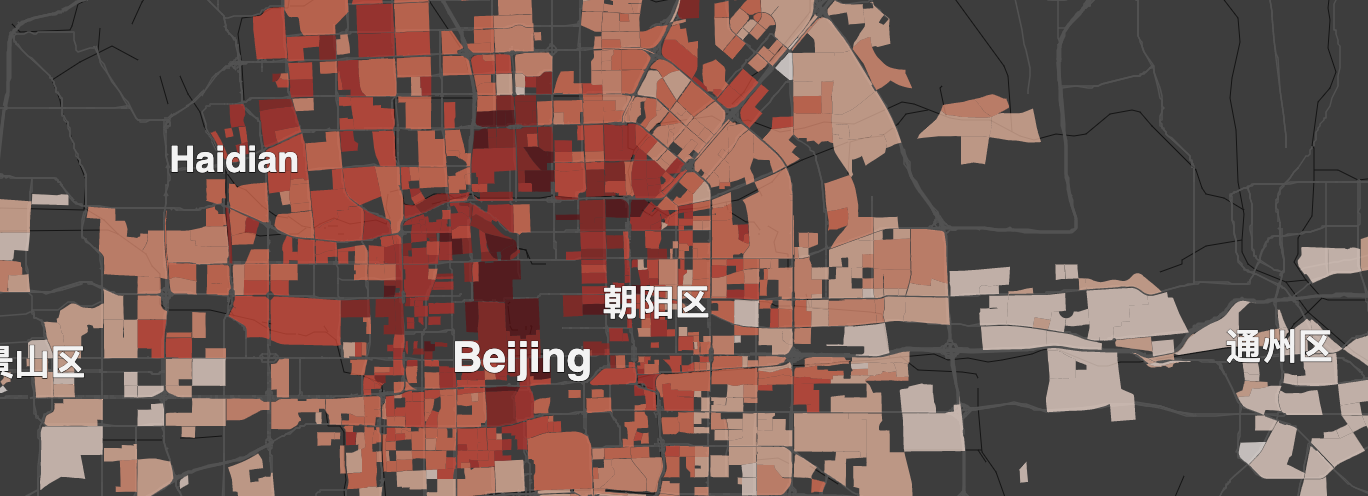

**Spatial joining** is similar to joining data by attributes, but instead of using key attributes, it uses locations to join tables.

For example, a table containing points can be spatially joined with a table containing areas (Polygons) basing on "within" relationship.

In this notebook we will spatially join the Beijing listings dataset and Beijing city-blocks (polygons). 

Then we will create a choropleth map showing an average property price (per square) by city-blocks.


### Libraries

- Geopandas: geo-dataframe and spatial operations.
- Rtree: used by Geopandas for spatial indexing.
- [Lets-Plot](https://pypi.org/project/lets-plot/): all plotting, including interactive maps.

In [ ]:
!pip install Rtree -U

In [ ]:
!pip install Lets-Plot -U

In [ ]:
import pandas as pd
import geopandas as gpd
from lets_plot import *

LetsPlot.setup_html()
LetsPlot.set(maptiles_lets_plot(theme="dark"))

### Beijing city-blocks

The Beijing city-blocks geojson file can be downloaded from this [GitHub repository](https://github.com/alshan/china-city-blocks).

In [ ]:
city_blocks = gpd.read_file("https://github.com/alshan/china-city-blocks/raw/main/output/beijing_city_blocks_2016.geojson")

# Add some kind of ID to city-blocks.
city_blocks["block_id"] = [i for i in range(0, city_blocks.shape[0])]
city_blocks.head(3)

#### Quick peek at city-blocks of Beijing.

In [ ]:
ggplot() + geom_map(map=city_blocks)

### Beijing listings: brief EDA and data preparation

In [ ]:
listings = pd.read_csv('/kaggle/input/lianjia/new.csv')
listings.shape

In [ ]:
# Select the columns we need and check for missing values.
listings = listings[['Lng', 'Lat', 'tradeTime', 'price', "district"]]
listings.isnull().sum()

In [ ]:
# Replace 'tradeTime' with just 'year' (Integer).
listings['year'] = pd.DatetimeIndex(listings['tradeTime']).year
listings.drop(['tradeTime'], axis=1, inplace=True)

In [ ]:
# The price dynamics over the years.

# According to the dataset description, the 'price' column contains avg. price per square.
(ggplot(listings) + 
 geom_point(aes(x='year', y='price'), position='jitter') + 
 geom_smooth(aes(x='year', y='price'), method='lm', deg=2, size=3) +
 scale_x_continuous(format=".0d"))


In [ ]:
# The price is rising fast.
# Let's continue with the listings from just one year - 2017.
listings_17 = listings[listings.year == 2017]

In [ ]:
# The price distribution is typical for property prices.

p = ggplot(listings_17) + geom_density(aes(x='price', y='..scaled..'))
p

In [ ]:
# Faceted plot show no anomalies in any of the Beijing districts.

p + facet_wrap(facets = "district")

### The Beijing choropleth map

Steps:

1. Convert "Lng"&"Lat" in Beijing listings to [shapely](https://github.com/Toblerity/Shapely) points and create a Geopandas GeoDataframe.
1. Spatially join the listings GeoDataframe and city-blocks (also GeoDataframe).
1. Compute avg. price (per square) in each city-block.
1. Use `geom_livemap()` and `geom_polygon()` to build an interactive choropleth map.

#### 1. GeoDataframe from Beijing listings.

In [ ]:
listings_17_gdf = gpd.GeoDataFrame(listings_17,
                        geometry=gpd.points_from_xy(listings_17.Lng,
                                                    listings_17.Lat,
                                                    crs="EPSG:4326")).reset_index(drop=True)
listings_17_gdf.head(3)

#### 2. Spatial Join.

Joining Beijing's listings and city blocks using "within" relationship.

In [ ]:
listings_17_with_block_id = gpd.sjoin(listings_17_gdf, 
                                      city_blocks[["block_id", "geometry"]], 
                                      how="inner", op='within').reset_index(drop=True)

listings_17_with_block_id.head(3)

#### 3. City-block avg. price.

After joining listings and city-blocks we've got the "block_id" column added to the listings dataset.

Now we can compute various aggregations by this column.

In [ ]:
# Compute mean price by city-block.
city_block_price = listings_17_with_block_id[[
    'price',
    'district', 
    'block_id']].groupby("block_id").mean('price').reset_index()
city_block_price.head(3)

#### 4. An interactive choropleth map.

In [ ]:
# A large number of city-blocks were not assigned a value 
# because there were no properties within these city-blocks listed in the year 2017.

print("Empty city-blocks count: {}".format(city_blocks.shape[0] - city_block_price.shape[0]))

# Let's remove "empty" city blocks - we don't need them on the choropleth.

# Perform "inner" join between the city-blocks (polygons) and the city-block prices datasets.
# This is a regular joining by a column (i.e. the "block_id" column).

# After this joining we will also have both: block price and block geometry in one dataset.

city_block_price_with_geom = pd.merge(city_block_price, city_blocks, on="block_id", how="inner")
city_block_price_with_geom = gpd.GeoDataFrame(city_block_price_with_geom)
print(city_block_price_with_geom.shape)
city_block_price_with_geom.head(3)

In [ ]:
# Create a choropleth map. 
# 
# - `geom_livemap()` creates an interactive base-map plot layer.
# - `geom_polygon()` adds a choropleth layer to the plot.

(ggplot() +
 geom_livemap(zoom=11) +
 geom_polygon(aes(fill="price"),
              alpha=.7,
              data=city_block_price_with_geom,
              tooltips=layer_tooltips()
              .line("District @district")
              .line("Price per square|@price")
              .format("district", ".0d").format("price", ".0d")
              .color("black")) +
 scale_fill_brewer(palette="Reds") + 
 ggsize(800, 655)
)

### To be continued...

Try spatial correlation and may be other geospatial analysis methods...